<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S06_Descriptive_Analytics/S06_LectureEx_Data_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S6 - Descriptive Data Modeling
Programming topics covered in this section:
* Data transformation for descriptive analytics
* Clustering and segmentation models

Examples include:
* Transportation shipment data analytics

In [1]:
import pandas as pd

## 1. Importing data and creating a report
In this exercise, we will explore some adapted data set which provides supply chain health commodity shipment and pricing data. Specifically, the data set identifies Antiretroviral (ARV) and HIV lab shipments to supported countries. In addition, the data set provides the commodity pricing and associated supply chain expenses necessary to move the commodities to countries for use. The original data are provided by the US Agency for International Development and can be accessed at [this page](https://catalog.data.gov/dataset/supply-chain-shipment-pricing-data).

This is a description of our adapted data in the file `SCMS_Delivery_History_Dataset.csv`.

| VARIABLE NAME | DESCRIPTION | 
|:----|:----|
|id| identification number|
|project code|identification of the project|
|country|country to which the items are shipped|
|vendor|identification of the vendor of the item|
|manufacturing site|name of the manufacturer of the item|
|shipment mode|transportation mode (e.g., air, truck)|
|scheduled delivery date|programmed date for delivery|
|delivered to client date|real date of delivery|
|delivery recorded date|registered date of delivery|
|product group|main category of the item|
|product subgroup|subcategory of the item (e.g., HIV test, pediatric, Adult) |
|molecule type|description of the composition of the item (e.g., Nevirapine, HIV 1/2, Didanosine)|
|brand| item brand (e.g, generic or any other commercial brand)|
|dosage| specifications about the dosage of each item (e.g.,10mg/ml, 200mg)|
|dosage form|instructions for consumption (e.g., capsule, tablet, oral solution) |
|units per pack| number of units in each package|
|quantity pack sold| number of packages shipped to the specified country|
|value sold| total value in $\$$ USD of the shipment (i.e., pack_price * quantity pack sold|
|pack price| price in $\$$ USD per package|
|unit price| price in $\$$ USD per unit|
|weight (kilograms)| total weight in kilograms of the shipment|
|freight cost (usd)| value in $\$$USD paid for transportation|
|insurance (usd)|value in $\$$USD paid for insurance|



Let's import our data.

In [53]:
url = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S05_Data_Preprocessing/Supply_Chain_Shipment_Pricing_Data.csv'
df_SC = pd.read_csv(url)  # reading data file into a DataFrame

df_SC.columns = df_SC.columns.str.replace(' ', '_')
df_SC.columns = df_SC.columns.str.replace('(', '')
df_SC.columns = df_SC.columns.str.replace(')', '')
df_SC.columns = df_SC.columns.str.replace('#', '')
df_SC.columns = df_SC.columns.str.replace('/', '')

df_SC['pq_first_sent_to_client_date'] = pd.to_datetime(df_SC['pq_first_sent_to_client_date'], errors='coerce')
df_SC['scheduled_delivery_date'] = pd.to_datetime(df_SC['scheduled_delivery_date'], errors='coerce')
df_SC['delivered_to_client_date'] = pd.to_datetime(df_SC['delivered_to_client_date'], errors='coerce')
df_SC['weight_kilograms'] = pd.to_numeric(df_SC['weight_kilograms'], errors='coerce')
df_SC['freight_cost_usd'] = pd.to_numeric(df_SC['freight_cost_usd'], errors='coerce')

df_SC = df_SC[(df_SC['freight_cost_usd'].notna()) & df_SC['weight_kilograms'] & (df_SC['delivered_to_client_date'] >= '2010-01-01')]

selected_columns = ['country', 'line_item_value','weight_kilograms','freight_cost_usd']
print(df_SC.isna().sum())

df_SC_selected = df_SC[selected_columns].groupby(['country']).agg({'line_item_value':'sum','weight_kilograms':'mean','freight_cost_usd':'mean'})
df_SC_selected.columns = ['total_value','average_weight','average_freight']

id                                0
project_code                      0
pq_                               0
po__so_                           0
asndn_                            0
country                           0
managed_by                        0
fulfill_via                       0
vendor_inco_term                  0
shipment_mode                     0
pq_first_sent_to_client_date      5
po_sent_to_vendor_date            0
scheduled_delivery_date           0
delivered_to_client_date          0
delivery_recorded_date            0
product_group                     0
sub_classification                0
vendor                            0
item_description                  0
moleculetest_type                 0
brand                             0
dosage                          906
dosage_form                       0
unit_of_measure_per_pack          0
line_item_quantity                0
line_item_value                   0
pack_price                        0
unit_price                  

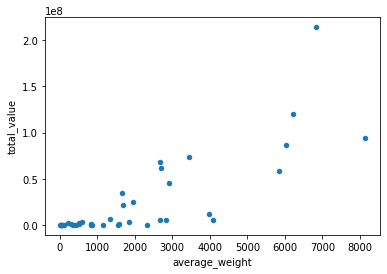

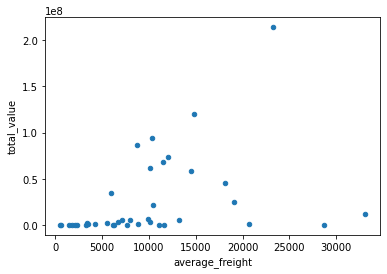

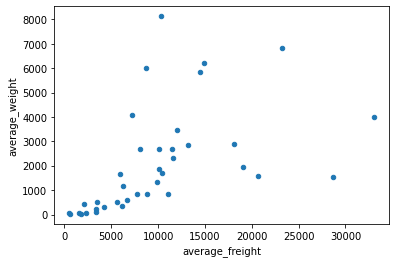

In [54]:
# ['total_value','total_weight','average_freight']
df_SC_selected.plot(kind = 'scatter', y='total_value', x = 'average_weight')
df_SC_selected.plot(kind = 'scatter', y='total_value', x = 'average_freight')
df_SC_selected.plot(kind = 'scatter', y='average_weight', x = 'average_freight')

As the table is relatively large, we only choose our column of interest to be put in the DataFrame:



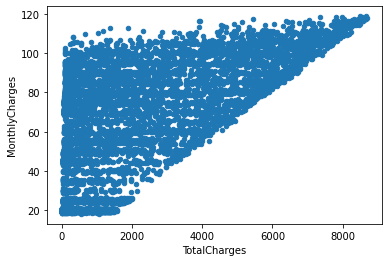

In [20]:
selected_columns = ['TotalCharges', 'MonthlyCharges']

df_cluster = df_telco[selected_columns].copy() # we make a copy of this to avoid any issue

df_cluster.plot(kind = 'scatter', x = 'TotalCharges', y = 'MonthlyCharges')

In [8]:
import sklearn
from sklearn.impute import KNNImputer

# First we determine which columns we want to use as references for matching
inferred_columns = ['line_item_value','weight_kilograms']
# Copy only the relevant columns to the new DataFrame
df_SC_kNN = df_SC[inferred_columns].copy()
# Add the column `line_item_insurance_(usd)` which we want to impute and assigns a new name to it
df_SC_kNN['item_insurance_rp_kNN'] = df_SC['freight_cost_usd']

# Set up the imputer object with the number of neighbors = 2 
imputer = sklearn.impute.KNNImputer(n_neighbors=3)
# Train to determine the neighbors and estimate the new values for all the missing values.
# This process might be time consuming if the size of the data and neighborhood are large.
# The new values are then assigned back to the DataFrame. # Since the method return an array (not a DataFrame), 
# we need to assign it back to the array values of the DataFrame, i.e., `df_SC_kNN[:]`
df_SC_kNN[:] = imputer.fit_transform(df_SC_kNN)

ValueError: ignored

The column `item_description` provides the description of product. However, we can also assign a unique (distinct) number to each product as well. `pandas` offers a function to create a list of unique ID and map this to the original column by using `factorize` method ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html)). This can be done as follows.

In [ ]:
# `codes` gives a list of new values after mapping and `uniques` gives the list of unique values
codes, uniques = pd.factorize(df_SC['item_description']) 

# we now modify the ID a bit and put in the format of 'SKU0000'
codes = ["SKU"+'{:04d}'.format(i) for i in codes]
print(codes)

We can then add a new column to the DataFrame in front of the `item_description` column 

In [ ]:
df_SC.insert(7,'item_id',codes)
df_SC


---
## 2. Preprocessing Data

We can use `df.describe()` function to show descriptive statistics of the numerical data

In [ ]:
df_SC.describe()

Let's take a look at the type of data in our `DataFrame`. We can notice that column `scheduled_delivery_date` is `object`, which means it can be string or mixed.

In [ ]:
df_SC.dtypes

Let's convert the data in column `schedule_delivery_date` to the correct format, as presented below. We can obtain the same results using the function `DataFrame.astype('datatime64')`

In [ ]:
# here we replace the original column with the newly formatted one
df_SC['scheduled_delivery_date'] = pd.to_datetime(df_SC['scheduled_delivery_date'])
df_SC['scheduled_delivery_date']

We can also see that the columns `weight_kilograms` and `freight_cost_usd` are also of type `object`. These data should be a numeric value since it represents kilograms and $USD. However, the raw data have some annotations made by the user, as you can see below by printing the first 10 rows of your DataFrame, so this is why it is recognized as type `object`.

In [ ]:
df_SC[['weight_kilograms','freight_cost_usd']].head(10)

We can then use the `to_numeric` method in order to convert the values under the `weight_kilograms` and `freight_cost_usd`  columns into a float:

In [ ]:
df_SC['weight_kilograms'] = pd.to_numeric(df_SC['weight_kilograms'], errors='coerce')
df_SC['freight_cost_usd'] = pd.to_numeric(df_SC['freight_cost_usd'], errors='coerce')
df_SC[['weight_kilograms','freight_cost_usd']].head(10)

By setting `errors='coerce'`, you will transform the non-numeric values into `NaN`.
Now we can obtain some descriptive statistics for `weight_kg` and `freight_cost_usd` using the `describe()` method.

In [ ]:
df_SC.describe()

---
## 3. Missing data

Now let's take a look at the missing values in our DataFrame. We can see how many missing values we have at each column as follows.

In [ ]:
df_SC.isnull().sum()


We can notice that there are some missing values in the column `shipment_mode`, which represents the transportation mode (e.g., by air). There is not that much we can do in order to replace these missing values with meaningful information, so we'll replace the missing values of in these columns with the word `'missing'`. We use the `.fillna()` method with the option `inplace=True` to save the changes in our original DataFrame. Check [this page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) for more information about the `.fillna()` method.

In [ ]:
df_SC.fillna(value={'shipment_mode': 'missing'}, inplace=True)
df_SC.isnull().sum()

In [ ]:
df_SC.line_item_insurance_usd 

Now we will replace the missing values in column `line_item_insurance_usd` by an approximated value, computed as the mean value for this column. Note that we create a new column for this.

In [ ]:
insurance_mean = df_SC['line_item_insurance_usd'].mean()
df_SC['item_insurance_rp_mean'] = df_SC['line_item_insurance_usd'].fillna(insurance_mean)
df_SC[['line_item_insurance_usd','item_insurance_rp_mean']][df_SC['line_item_insurance_usd'].isna() == True]



The issue about replacing the `NaN` value by the mean or another constant is that it disregards other features/values of the data point. To overcome this is issue, we can opt to impute each missing value by using an estimation or prediction based on other data points. One practical method is to use the k-nearest neighbors (KNN) algorithm for imputation. More details can be found in this [link1](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) and this [link2](
https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/) This can be done using the code below which take the weighted sum of the values from the two closest data points to each missing value.

In [ ]:
import sklearn
from sklearn.impute import KNNImputer

# First we determine which columns we want to use as references for matching
inferred_columns = ['line_item_value','weight_kilograms', 'freight_cost_usd']
# Copy only the relevant columns to the new DataFrame
df_SC_kNN = df_SC[inferred_columns].copy()
# Add the column `line_item_insurance_(usd)` which we want to impute and assigns a new name to it
df_SC_kNN['item_insurance_rp_kNN'] = df_SC['line_item_insurance_usd']

# Set up the imputer object with the number of neighbors = 2 
imputer = sklearn.impute.KNNImputer(n_neighbors=2)
# Train to determine the neighbors and estimate the new values for all the missing values.
# This process might be time consuming if the size of the data and neighborhood are large.
# The new values are then assigned back to the DataFrame. # Since the method return an array (not a DataFrame), 
# we need to assign it back to the array values of the DataFrame, i.e., `df_SC_kNN[:]`
df_SC_kNN[:] = imputer.fit_transform(df_SC_kNN)

# copy the new column to t
df_SC['item_insurance_rp_kNN'] = df_SC_kNN['item_insurance_rp_kNN'].copy()

In [ ]:
# Now we can examine the results
df_SC[['item_insurance_rp_mean','item_insurance_rp_kNN']][df_SC['line_item_insurance_usd'].isna() == True]

In [ ]:
df_SC.isna().sum()

---
## 4. Data Transformation

### Scaling methods
Variables tend to have different ranges and some algorithms are adversely affected by differences in variable ranges. Variables with greater ranges tend to have larger influence on data model’s results. Therefore, numeric field values may need to be standardized/normalized. 

From the output of the `describe()` method in the previous line of code, we can notice that the numerical variables have different ranges. For instance, `units_per_pack` varies from 1 to 1000, while `weight_kg` varies from 0 to 857354. We would like to apply normalization method to scale the numerical values in our data. 

Let's apply the **min-max normalization** and **z-score normalization** methods, by identifying how much greater the field value is than the minimum value, and scaling this difference by the range of field values.

$$X^{norm}_i=\frac{X_i-X_{min}}{X_{max}-X_{min}}$$
and
$$Z_i=\frac{X_i-X_{mean}}{\sigma_X}$$
Thus,  I compute the normalized version of each of the numerical variable and add this as a new column of our data frame. We can proceed as follows. 

First, we create a list of the columns we want to normalize. 

In [ ]:
columns_to_norm = ['line_item_quantity',	'line_item_value']

Then, I can create a `for` loop to compute the normalized version for each one of these columns and add it to `df_SC`. 

In [ ]:
for col in columns_to_norm:
    df_SC[col + '_norm'] = (df_SC[col] - df_SC[col].min())/(df_SC[col].max() - df_SC[col].min())   # add the new normalized column
    df_SC[col + '_z'] = (df_SC[col] - df_SC[col].mean())/df_SC[col].std()    # add the new z-norm column
    

In [ ]:
df_SC[['line_item_value','line_item_value_norm','line_item_value_z']].describe()

In order to deal with **skewed data**, we can also use a scaling technique (such as log transformation). For example, we ca transform the column `line_item_value` as follows.

In [ ]:
# first we evaluate the distribution of the value
df_SC[['line_item_value']].plot(kind = 'hist')

# apply the transformation
import math
# note that math.log calculates a natural log (i.e., ln(x)). Using x + 1 is a workaround to deal with 0 
df_SC['line_item_value_log'] = [math.log(x+1) for x in df_SC['line_item_value']]

# sqrt transformation
df_SC['line_item_value_sqrt'] = [math.sqrt(x) for x in df_SC['line_item_value']]

# plot to compare the results
df_SC[['line_item_value','line_item_value_log']].plot(x = 'line_item_value_log', y = 'line_item_value', kind = 'scatter')
df_SC[['line_item_value_log']].plot(kind = 'hist')

df_SC[['line_item_value','line_item_value_sqrt']].plot(x = 'line_item_value_sqrt', y = 'line_item_value', kind = 'scatter')
df_SC[['line_item_value_sqrt']].plot(kind = 'hist')


### Dummy Variables
A categorical variable should generally be encoded as **dummy variables** (a.k.a. indicator variables), each taking only one of two values (0 or 1; False or True)
When a categorical variable takes k possible values, you typically have two options to define your dummy variables:
* Option 1: Define k-1 dummy variables, and use the unassigned category as the reference category. This is often referred to as **dummy** encoding. This is typically a preferred option to avoid multicolinearity (dummy variable trap: see [link](https://en.wikipedia.org/wiki/Dummy_variable_(statistics))) when using linear regression technique.
* Option 2: Define k dummy variables. Often referred to as **one-hot** encoding. This is more commonly used when employing modern machine learning algorithms which include regularization. In this case, the one additional input of all zeroes would represent a missing value (in addition to the categorical values as in dummy encoding). 

Let's transform our categorical variable `shipment` using these two options. First, let's take a look at the possible values for the categorical values.

In [ ]:
df_SC['shipment_mode']

We will create 4 dummy variables with names `'Air'`,  `'Truck'`, `'Air Charter'` and `'Ocean'`, and use `'missing'` as our reference category. One way to do this is by making use of the `DataFrame` function `pd.get_dummies()`, which automatically  converts categorical variable into dummy/indicator variables. If you  You can check [this page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) for more information. Then, we can add the new `DataFrame` we just created (`df_dummies`) to our original `DataFrame`. 

In [ ]:
df_dummies = pd.get_dummies(df_SC['shipment_mode'], drop_first=True)
df_dummies.head()

In [ ]:
df_onehot = pd.get_dummies(df_SC['shipment_mode'])
df_onehot.head()

Then, we can add the new `DataFrame` we just created (`df_dummies`) to our original `DataFrame`.  We can do this using the function `pd.concat()`.

In [ ]:
# concatenating the original df_SC with df_dummy
df_SC = pd.concat([df_SC, df_onehot], axis=1) 
df_SC[['shipment_mode']+list(df_onehot.columns)].describe()

In [ ]:
df_SC

## Transforming numerical variables into categorical variables
In some cases, categorical variables may be preferred over numerical ones. We then need to partition the numerical variables into bins according to a specific criteria.
As an example, let's transform our original variable `weight_kilograms` into a categorical variable with values `'light'` (if the weight is up to 100 kg), `'medium'`(if the weight is within the interval (100 kg, 500 kg]), `'heavy'` (if the weight is within the interval (500 kg, 1000 kg]) and `'super-heavy'`(if the weight is > 1000 kg). 

We can implement this transformation using the function `pd.cut()`, which helps us to segment and sort data values into bins. You can check [this page](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) for more information on this function.


In [ ]:
bins = [0, 100., 500., 1000.,  float('inf')]             # defining the bins 
names = ['light', 'medium', 'heavy', 'super-heavy']      # defining the names for the categories
df_SC['weight_category'] = pd.cut(df_SC['weight_kilograms'], bins, labels=names, include_lowest=True)  # adding the new cat. var. to our DF
df_SC[['weight_kilograms','weight_category']][df_SC['weight_kilograms'] == df_SC['weight_kilograms'].min()]

In [ ]:
save_file = "transformed_df.csv"
df_SC.to_csv(save_file)

In [ ]:
#for Colab, you need to run this one to download the file above
from google.colab import files
files.download(save_file)